# Collaborative Filtering of Movies Dataset

In [680]:
import pandas as pd
import numpy as np
import seaborn as sns
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

## 1. Load The Dataset

In [681]:
dfRating = pd.read_csv("../data/reference_two/ratings.csv")
dfMovies = pd.read_csv("../data/reference_two/movies.csv")

In [682]:
dfRating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [683]:
dfMovies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [684]:
dfRating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [685]:
dfMovies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [686]:
numUser = len(dfRating.userId.unique())
numMovie = len(dfMovies.movieId.unique())

print("There are {} unique users and {} unique movie".format(numUser, numMovie))

There are 610 unique users and 9742 unique movie


## 2. Exploratory Data Analysis

#### 2.1. Plot the Counts of Each Rating

In [687]:
# get count of rating
dfRatingCountTmp = pd.DataFrame(dfRating.groupby('rating').size(), columns=['count'])
dfRatingCountTmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [688]:
# there are a lot more counts in rating of zero
totalCount = numUser * numMovie
ratingZeroCount = totalCount - dfRating.shape[0]

# append count of zero rating to dfRatingCount
dfRatingCount = pd.DataFrame({'rating': [0], 'count': [ratingZeroCount]})
dfRatingCount = pd.concat([dfRatingCountTmp.reset_index(), dfRatingCount], ignore_index=True)
dfRatingCount

,rating,count
0,0.5,1370
1,1.0,2811
2,1.5,1791
3,2.0,7551
4,2.5,5550
5,3.0,20047
6,3.5,13136
7,4.0,26818
8,4.5,8551
9,5.0,13211


In [689]:
dfRatingCount['log_count'] = np.log(dfRatingCount['count'])
dfRatingCount

,rating,count,log_count
0,0.5,1370,7.222566
1,1.0,2811,7.941296
2,1.5,1791,7.490529
3,2.0,7551,8.929435
4,2.5,5550,8.621553
5,3.0,20047,9.905835
6,3.5,13136,9.483112
7,4.0,26818,10.196829
8,4.5,8551,9.053804
9,5.0,13211,9.488805


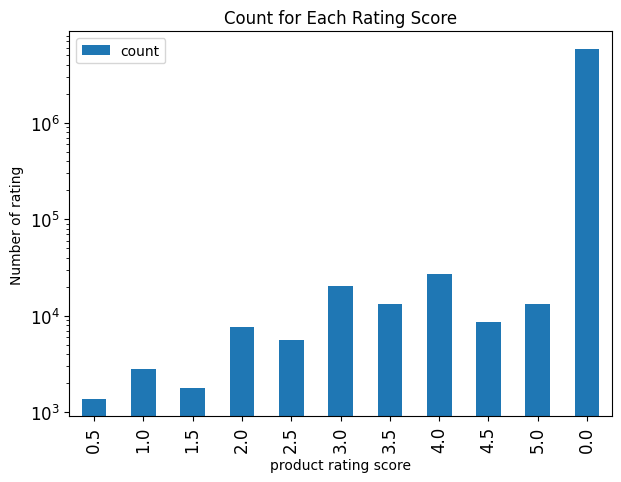

In [690]:
ax = dfRatingCount.reset_index().plot(
    x='rating',
    y='count',
    kind='bar',
    figsize=(7, 5),
    title='Count for Each Rating Score',
    logy=True,
    fontsize=12,
)

plt.xlabel('product rating score')
plt.ylabel('Number of rating')
plt.show()

#### 2.2. Plot Rating Frequency of All Movies

In [691]:
dfRating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [692]:
# get rating frequency
dfMoviesCount = pd.DataFrame(dfRating.groupby('movieId').size(), columns=['count'])
dfMoviesCount.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'Number of Rating')

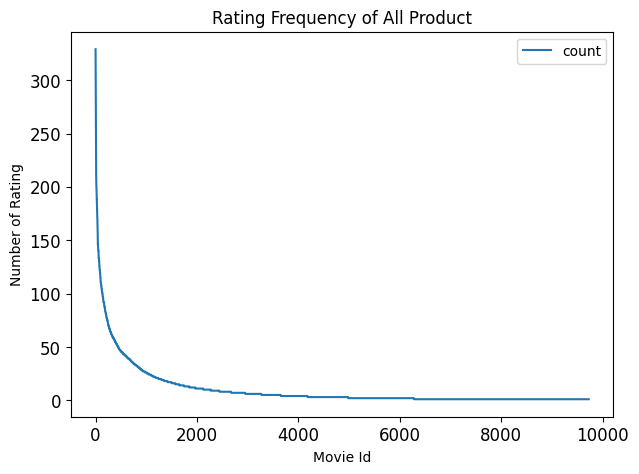

In [693]:
ax = dfMoviesCount \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(7,5),
        title='Rating Frequency of All Product',
        fontsize=12
    )
ax.set_xlabel("Movie Id")
ax.set_ylabel("Number of Rating")

Text(0, 0.5, 'Number of Rating')

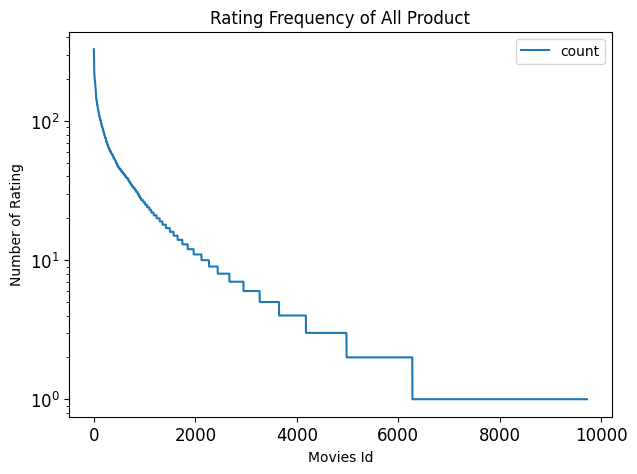

In [694]:
ax = dfMoviesCount \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(7,5),
        title='Rating Frequency of All Product',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("Movies Id")
ax.set_ylabel("Number of Rating")

In [695]:
dfMoviesCount['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

In [696]:
# filter data
popularityThres = 50
popularMovie = list(set(dfMoviesCount.query('count >= @popularityThres').index))
dfRatingDropMovies = dfRating[dfRating.movieId.isin(popularMovie)]
print('Shape of original rating data: ', dfRating.shape)
print('Shape of rating data after dropping unpopular movie: ', dfRatingDropMovies.shape)

Shape of original rating data:  (100836, 4)
Shape of rating data after dropping unpopular movie:  (41360, 4)


In [697]:
dfUserCount = pd.DataFrame(dfRatingDropMovies.groupby('userId').size(), columns=['count'])
dfUserCount.head()

,count
userId,
1,117
2,15
3,6
4,84
5,34


Text(0, 0.5, 'Number of Rating')

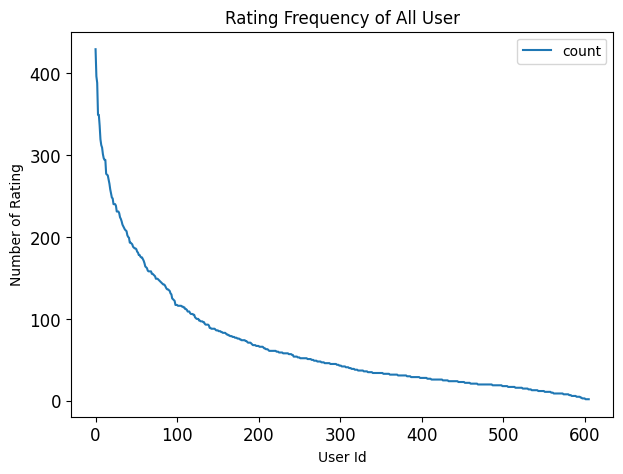

In [698]:
ax = dfUserCount \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(7,5),
        title='Rating Frequency of All User',
        fontsize=12
    )
ax.set_xlabel("User Id")
ax.set_ylabel("Number of Rating")

In [699]:
dfUserCount['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    429.00
0.95    223.50
0.90    166.00
0.85    134.25
0.80    105.00
0.75     85.00
0.70     74.00
0.65     62.25
0.60     56.00
0.55     48.00
Name: count, dtype: float64

In [700]:
# filter data
popularityThres = 50
popularUser = list(set(dfUserCount.query('count >= @popularityThres').index))
dfRatingDropUser = dfRatingDropMovies[dfRatingDropMovies.userId.isin(popularUser)]
dfRatingDropUser.reset_index(drop=True, inplace=True)
print('Shape of original rating data: ', dfRating.shape)
print('Shape of rating data after dropping unpopular user: ', dfRatingDropUser.shape)

dfRatingFix = dfRatingDropUser.drop(columns=['timestamp'])

Shape of original rating data:  (100836, 4)
Shape of rating data after dropping unpopular user:  (32999, 4)


## 3. Prepare the Data

In [701]:
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

In [702]:
# pivot and create movie-user matrix
movieUserMatrix = dfRatingFix.pivot_table(index='movieId', columns='userId', values='rating', fill_value=0)
movieUserMatrix.reset_index(drop=True, inplace=True)
movieUserMatrix.columns = range(len(movieUserMatrix.columns))
movieUserMatrix

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
0,4,0,0,4.5,2.5,0.0,4.5,3.5,4,0.0,...,2.5,4.0,0,4,3,4.0,2.5,4,2.5,5.0
1,0,0,4,0.0,0.0,0.0,0.0,3.0,3,3.0,...,4.0,0.0,4,0,5,3.5,0.0,0,2.0,0.0
2,4,0,5,0.0,0.0,0.0,0.0,0.0,3,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,2.0,0.0
3,4,0,4,0.0,0.0,0.0,0.0,4.0,0,0.0,...,0.0,0.0,3,4,3,0.0,0.0,0,0.0,5.0
4,0,0,4,0.0,0.0,0.0,0.0,0.0,2,0.0,...,3.5,0.0,0,0,0,0.0,2.5,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0,0,0,0.0,2.0,0.0,0.0,4.0,0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0.0,4.5
446,0,0,0,0.0,4.0,0.0,0.0,4.5,0,0.0,...,0.0,5.0,0,0,0,0.0,0.0,0,0.0,3.5
447,0,0,0,0.0,1.5,0.0,0.0,4.5,0,0.0,...,0.0,4.0,0,0,0,0.0,0.0,0,0.0,4.5
448,0,0,0,0.0,0.0,0.0,0.0,4.5,0,0.0,...,0.0,4.0,0,0,0,0.0,0.0,0,0.0,0.0


## 4. Train KNN Model

In [703]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [704]:
movieUserMatrix

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
0,4,0,0,4.5,2.5,0.0,4.5,3.5,4,0.0,...,2.5,4.0,0,4,3,4.0,2.5,4,2.5,5.0
1,0,0,4,0.0,0.0,0.0,0.0,3.0,3,3.0,...,4.0,0.0,4,0,5,3.5,0.0,0,2.0,0.0
2,4,0,5,0.0,0.0,0.0,0.0,0.0,3,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,2.0,0.0
3,4,0,4,0.0,0.0,0.0,0.0,4.0,0,0.0,...,0.0,0.0,3,4,3,0.0,0.0,0,0.0,5.0
4,0,0,4,0.0,0.0,0.0,0.0,0.0,2,0.0,...,3.5,0.0,0,0,0,0.0,2.5,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0,0,0,0.0,2.0,0.0,0.0,4.0,0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0.0,4.5
446,0,0,0,0.0,4.0,0.0,0.0,4.5,0,0.0,...,0.0,5.0,0,0,0,0.0,0.0,0,0.0,3.5
447,0,0,0,0.0,1.5,0.0,0.0,4.5,0,0.0,...,0.0,4.0,0,0,0,0.0,0.0,0,0.0,4.5
448,0,0,0,0.0,0.0,0.0,0.0,4.5,0,0.0,...,0.0,4.0,0,0,0,0.0,0.0,0,0.0,0.0


In [705]:
#define model
knnModel = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)

#fit
knnModel.fit(movieUserMatrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

In [706]:
def train_model(data_train, num_neighbors):
    model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=num_neighbors, n_jobs=-1)
    model.fit(data_train)

    return model


# train_data, test_data = train_test_split(movieUserMatrix, test_size=0.2, random_state=42)
knnTest = train_model(movieUserMatrix.values, 5)
distances, indices = knnTest.kneighbors(movieUserMatrix.values, n_neighbors=5)

In [707]:
indices

array([[  0,  81,  62,  44, 152],
       [  1,  64,  81,  96,  83],
       [  2,  55,  41, 117,  92],
       ...,
       [447, 439, 449, 441, 419],
       [448, 438, 445, 446, 447],
       [449, 447, 441, 443, 439]], dtype=int64)

In [708]:
distances

array([[0.00000000e+00, 2.79778912e-01, 3.06810336e-01, 3.25844841e-01,
        3.26705848e-01],
       [5.55111512e-16, 3.63534857e-01, 3.92768963e-01, 3.95644481e-01,
        3.96067582e-01],
       [0.00000000e+00, 4.54599328e-01, 4.74784980e-01, 4.96629379e-01,
        5.30368645e-01],
       ...,
       [2.22044605e-16, 1.86585460e-01, 2.89615908e-01, 3.34663716e-01,
        3.52568294e-01],
       [0.00000000e+00, 3.80893246e-01, 4.03748598e-01, 4.04604806e-01,
        4.70520976e-01],
       [0.00000000e+00, 2.89615908e-01, 3.43251676e-01, 3.43677276e-01,
        3.66820805e-01]])

## 5. Recommendation

#### 5.1. Found the similarity

In [709]:
for title in movieUserMatrix.index:
    indexUserLikes = movieUserMatrix.index.tolist().index(title)
    simMovie = indices[indexUserLikes].tolist()
    movieDistance = distances[indexUserLikes].tolist()
    idMovie = simMovie.index(indexUserLikes)

    print('Similar movie to ' + str(movieUserMatrix.index[indexUserLikes]) + ':\n')

    simMovie.remove(indexUserLikes)
    movieDistance.pop(idMovie)

    j = 1
    for i in simMovie:
        print(str(j) + ': ' + str(movieUserMatrix.index[i]) + ', the distance with movie liked is ' + str(movieDistance[j-1]))
        j += 1
    
    print('\n')


Similar movie to 0:

1: 81, the distance with movie liked is 0.2797789115289834
2: 62, the distance with movie liked is 0.3068103361462835
3: 44, the distance with movie liked is 0.32584484119025636
4: 152, the distance with movie liked is 0.3267058482475985


Similar movie to 1:

1: 64, the distance with movie liked is 0.3635348572272724
2: 81, the distance with movie liked is 0.39276896315493315
3: 96, the distance with movie liked is 0.3956444814332196
4: 83, the distance with movie liked is 0.39606758156028665


Similar movie to 2:

1: 55, the distance with movie liked is 0.45459932783747026
2: 41, the distance with movie liked is 0.4747849800571037
3: 117, the distance with movie liked is 0.4966293785728767
4: 92, the distance with movie liked is 0.530368644831382


Similar movie to 3:

1: 12, the distance with movie liked is 0.41808543593065284
2: 105, the distance with movie liked is 0.42973287068830923
3: 48, the distance with movie liked is 0.44036237200354966
4: 78, the dista

#### 5.2. Found Similar product to a selected Product

In [710]:
def recommendMovie(movie):
    indexUserLikes = movieUserMatrix.index.tolist().index(movie)
    simMovie = indices[indexUserLikes].tolist()
    movieDistances = distances[indexUserLikes].tolist()
    idMovie = simMovie.index(indexUserLikes)

    print('Similar movie to ' + str(movieUserMatrix.index[indexUserLikes]) + ':\n')

    simMovie.remove(indexUserLikes)
    movieDistances.pop(idMovie)

    j = 1
    for i in simMovie:
        print(str(j) + ': ' + str(movieUserMatrix.index[i]) + ', the distance with movie liked is ' + str(movieDistance[j-1]))
        j += 1
    
    print('\n')


In [711]:
recommendMovie(0)

Similar movie to 0:

1: 81, the distance with movie liked is 0.28961590760679445
2: 62, the distance with movie liked is 0.3432516757246983
3: 44, the distance with movie liked is 0.34367727591704333
4: 152, the distance with movie liked is 0.36682080543227324




#### 5.3. Recommend Product for a Selected User

In [834]:
# store the original dataset in 'df', and create the copy of df,
movieUserMatrixCopied = movieUserMatrix.copy()

def recommend_movies(user, num_recommended_movies):

  # print('The list of the Movies {} Has Watched \n'.format(user))

  # for m in movieUserMatrix[movieUserMatrix[user] > 0][user].index.tolist():
  #   print(m)
  
  # print('\n')

  recommended_movies = []

  for m in movieUserMatrix[movieUserMatrix[user] == 0].index.tolist():

    index_df = movieUserMatrix.index.tolist().index(m)
    predicted_rating = movieUserMatrixCopied.iloc[index_df, movieUserMatrixCopied.columns.tolist().index(user)]
    recommended_movies.append((m, predicted_rating))

  sorted_rp = sorted(recommended_movies, key=lambda x:x[1], reverse=True)
  
  print('The list of the Recommended movies \n')
  rank = 1
  for recommended_movie in sorted_rp[:num_recommended_movies]:
    print('{}: {} - predicted rating:{}'.format(rank, recommended_movie[0], recommended_movie[1]))
    rank = rank + 1

In [835]:
def movie_recommender(user, model, num_neighbors, num_recommendation):

  model.fit(movieUserMatrix.values)
  distances, indices = model.kneighbors(movieUserMatrix.values, n_neighbors=num_neighbors)

  user_index = movieUserMatrix.columns.tolist().index(user)

  # name: product name, idx: the row number of product in df
  for idxMovie, t in list(enumerate(movieUserMatrix.index)):
    
    # find movies without ratings by user
    if movieUserMatrix.iloc[idxMovie, user_index] == 0:
      sim_movies = indices[idxMovie].tolist()
      movie_distances = distances[idxMovie].tolist()

      # Generally, this is the case: indices[3] = [3 6 7]. The movie itself is in the first place.
      # In this case, we take off 3 from the list. Then, indices[3] == [6 7] to have the nearest NEIGHBORS in the list. 
      if idxMovie in sim_movies:
        id_movie = sim_movies.index(idxMovie)
        sim_movies.remove(idxMovie)
        movie_distances.pop(id_movie) 

      # However, if the percentage of ratings in the dataset is very low, there are too many 0s in the dataset. 
      # Some movies have all 0 ratings and the movies with all 0s are considered the same movies by NearestNeighbors(). 
      # Then,even the movie itself cannot be included in the indices. 
      # For example, indices[3] = [2 4 7] is possible if movie_2, movie_3, movie_4, and movie_7 have all 0s for their ratings.
      # In that case, we take off the farthest movie in the list. Therefore, 7 is taken off from the list, then indices[3] == [2 4].
      else:
        sim_movies = sim_movies[:num_neighbors-1]
        movie_distances = movie_distances[:num_neighbors-1]

      # movie_similarty = 1 - movie_distance
      movie_similarity = [1-x for x in movie_distances]
      movie_similarity_copy = movie_similarity.copy()
      # Nominator adalah jumlah keseluruhan dari perkalian antara similarity dan rating tiap anggota neighbors; syarat rating anggota != 0
      nominator = 0

      # for each similar movie
      for IdxOfS in range(0, len(movie_similarity)):
        
        # check if the rating of a similar movie is zero
        if movieUserMatrix.iloc[sim_movies[IdxOfS], user_index] == 0:
          
          # if the rating is zero, ignore the rating and the similarity in calculating the predicted rating
          if len(movie_similarity_copy) == (num_neighbors - 1):
            movie_similarity_copy.pop(IdxOfS)
          
          else:
            movie_similarity_copy.pop(IdxOfS-(len(movie_similarity)-len(movie_similarity_copy)))
                
        # if the rating is not zero, use the rating and similarity in the calculation
        else:
          nominator += movie_similarity[IdxOfS]*movieUserMatrix.iloc[sim_movies[IdxOfS],user_index]
      
      
      # check if the number of the ratings with non-zero is positive 
      if len(movie_similarity) > 0:

        # check if the sum of the ratings of the similar movies is positive.
        if sum(movie_similarity_copy) > 0:
          # menghitung nilai prediksi rating dengan membagi total kontribusi dari produk tetangga (nilai nominator) dengan total similarity produk yang masih dalam pertimbangan (nilai penyebut).
          # Ini memberikan bobot rata-rata dari kontribusi produk tetangga dalam prediksi rating produk saat ini.
          predicted_r = nominator/sum(movie_similarity_copy)
        
        # Even if there are some movies for which the ratings are positive, some movies have zero similarity even though they are selected as similar movies.
        # in this case, the predicted rating becomes zero as well  
        else:
          predicted_r = 0

      # if all the ratings of the similar movies are zero, then predicted rating should be zero
      else:
        predicted_r = 0
        
      movieUserMatrixCopied.iloc[idxMovie,user_index] = predicted_r
  recommend_movies(user, num_recommendation)

In [837]:
movie_recommender(0, knnTest, 10, 10)

The list of the Recommended movies 

1: 306 - predicted rating:5.000000000000001
2: 308 - predicted rating:5.000000000000001
3: 314 - predicted rating:5.000000000000001
4: 317 - predicted rating:5.000000000000001
5: 387 - predicted rating:5.000000000000001
6: 17 - predicted rating:5.0
7: 22 - predicted rating:5.0
8: 26 - predicted rating:5.0
9: 72 - predicted rating:5.0
10: 75 - predicted rating:5.0


In [716]:
# summ = 0
# for idx, user in movieUserMatrix.columns.iterrows():
#     username = user['username']
#     product_recommender(username, knn2, 5, 10)
#     summ +=1

# summ

# for index, row in enumerate(movieUserMatrix.columns):
#     movie_recommender(index, knnTest, 10, 10)

In [717]:
# Sparsity check

# sebelum prediksi rating
non_zero_count_old = movieUserMatrix.astype(bool).sum().sum()
total_possible_count_old = movieUserMatrix.shape[0] * movieUserMatrix.shape[1]
sparsity_old = 1 - (non_zero_count_old / total_possible_count_old)

# setelah prediksi rating
non_zero_count_new = movieUserMatrixCopied.astype(bool).sum().sum()
total_possible_count_new = movieUserMatrixCopied.shape[0] * movieUserMatrixCopied.shape[1]
sparsity_new = 1 - (non_zero_count_new / total_possible_count_new)

persentase_penurunan = ((sparsity_old - sparsity_new) / sparsity_old) * 100
print(round(persentase_penurunan, 2), "%")

0.0 %


In [718]:
movieUserMatrixCopied

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
0,4,0,0,4.5,2.5,0.0,4.5,3.5,4,0.0,...,2.5,4.0,0,4,3,4.0,2.5,4,2.5,5.0
1,0,0,4,0.0,0.0,0.0,0.0,3.0,3,3.0,...,4.0,0.0,4,0,5,3.5,0.0,0,2.0,0.0
2,4,0,5,0.0,0.0,0.0,0.0,0.0,3,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,2.0,0.0
3,4,0,4,0.0,0.0,0.0,0.0,4.0,0,0.0,...,0.0,0.0,3,4,3,0.0,0.0,0,0.0,5.0
4,0,0,4,0.0,0.0,0.0,0.0,0.0,2,0.0,...,3.5,0.0,0,0,0,0.0,2.5,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0,0,0,0.0,2.0,0.0,0.0,4.0,0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0.0,4.5
446,0,0,0,0.0,4.0,0.0,0.0,4.5,0,0.0,...,0.0,5.0,0,0,0,0.0,0.0,0,0.0,3.5
447,0,0,0,0.0,1.5,0.0,0.0,4.5,0,0.0,...,0.0,4.0,0,0,0,0.0,0.0,0,0.0,4.5
448,0,0,0,0.0,0.0,0.0,0.0,4.5,0,0.0,...,0.0,4.0,0,0,0,0.0,0.0,0,0.0,0.0


## 6. Evaluate the Model

In [719]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from math import sqrt
import math

In [723]:
def create_pivot_table(data_rating):
    # pivot and create product-user matrix
    itemUserMatrix = data_rating.pivot_table(index='movieId', columns='userId', values='rating', fill_value=0)
    itemUserMatrix.reset_index(drop=True, inplace=True)
    itemUserMatrix.columns = range(len(itemUserMatrix.columns))

    return itemUserMatrix

#### Setup K-Fold CV

In [722]:
# setting fold
num_folds = 5
# Inisialisasi KFold
kf = KFold(n_splits=num_folds, shuffle=True)

#### Optimasi nilai K pada KNN

In [720]:
k_values = [i for i in range (1,31)]
scores = []

#### Example K-Fold CV

In [726]:
def create_pivot_table(data_rating):
    # pivot and create product-user matrix
    trainMatrix = dfRatingDropUser.pivot_table(index='movieId', columns='userId', values='rating', fill_value=0)
    trainMatrix.reset_index(drop=True, inplace=True)
    trainMatrix.columns = range(len(movieUserMatrix.columns))

    return trainMatrix


def compute_mae(actual, predict):
    n = len(predict)
    MAE = sum(abs(actual - predict))/n
    
    return MAE


def k_fold_cv_mae(kFold, df_rating, num_neighbors):
    # Prepare the data
    movieUserMatrix = create_pivot_table(df_rating)
    
    cv_mae = []

    # enumerate splits
    for train_data, test_data in kFold.split(movieUserMatrix):
        train_data = list(train_data)
        train_data = movieUserMatrix.iloc[train_data, :]
        movieUserCsrMatrix = csr_matrix(train_data.values)

        test_data = list(test_data)
        test_data_actual = movieUserMatrix.iloc[test_data, :]
        test_data_predict = movieUserMatrix.iloc[test_data, :]

        print("---fold")
        print(test_data)


        # LOGIC HERE
        # Latih model pada train_data
        trained_model = train_model(movieUserCsrMatrix, num_neighbors)
        distances, indices = trained_model.kneighbors(movieUserMatrix.iloc[test_data[0], :].values.reshape(1,-1), n_neighbors=num_neighbors)
        print(indices)
        
        # predict_result = product_recommender_mae(trained_model, test_data, test_data_predict, train_data, num_neighbors)

        #prediction for test set
        # test['predict'] = ""
        
        # for i in range(len(test)):
        #     uid = test.iloc[i,0]
        #     iid = test.iloc[i,1]
        #     rui = test.iloc[i,2]


        #     # Filled predict column
        #     pred_pb = knn_pb.predict(uid, iid, r_ui = rui)
        #     test.iloc[i,3] = round(pred_pb.est,1)

        # #calculate MAE
        # mae_pb = compute_mae(test.iloc[:,2], test.iloc[:,3])
        # cv_mae.append(round(mae_pb,4))
        
    return cv_mae


# k_fold_cv_mae(kf, dfRating, 10)
# maeKfold = k_fold_cv_mae(kf, dfRatingFix, 5)
# maeKfold
# movieUserMatrix: 450 rows × 268 columns

#### The Logic for Evaluating

In [724]:
def product_recommender_mae(model, movieUserMatrix, num_neighbors):
    distances, indices = model.kneighbors(movieUserMatrix, n_neighbors=num_neighbors)
    dfResult = movieUserMatrix.copy()


    users = movieUserMatrix.columns.tolist()
    for user_column in users:
        user_index = users.index(user_column)
        
        for idxMovie, t in list(enumerate(movieUserMatrix.index)):
            # if movieUserMatrix.iloc[idxMovie, user_index] == 0:
            sim_movies = indices[idxMovie].tolist()
            movie_distances = distances[idxMovie].tolist()

            if idxMovie in sim_movies:
                id_movie = sim_movies.index(idxMovie)
                sim_movies.remove(idxMovie)
                movie_distances.pop(id_movie) 

            else:
                sim_movies = sim_movies[:num_neighbors-1]
                movie_distances = movie_distances[:num_neighbors-1]

            movie_similarity = [1-x for x in movie_distances]
            movie_similarity_copy = movie_similarity.copy()
            nominator = 0

            for IdxOfS in range(0, len(movie_similarity)):
                if movieUserMatrix.iloc[sim_movies[IdxOfS], user_index] == 0:
                    if len(movie_similarity_copy) == (num_neighbors - 1):
                        movie_similarity_copy.pop(IdxOfS)
                    else:
                        movie_similarity_copy.pop(IdxOfS-(len(movie_similarity)-len(movie_similarity_copy)))
                else:
                    nominator += movie_similarity[IdxOfS]*movieUserMatrix.iloc[sim_movies[IdxOfS],user_index]
            
            
            if len(movie_similarity) > 0:
                if sum(movie_similarity_copy) > 0:
                    predicted_r = nominator/sum(movie_similarity_copy)
                else:
                    predicted_r = 0
            
            else:
                predicted_r = 0
            

            dfResult.iloc[idxMovie,user_index] = predicted_r
                
    return dfResult

#### 6.1. MAE (Mean Absolute Error)

In [725]:
def compute_mae(df_rating, num_neighbors):
    # Prepare the data
    movieUserMatrix = create_pivot_table(df_rating)
    
    # LOGIC HERE
    # Latih model pada train_data
    trained_model = train_model(movieUserMatrix.values, num_neighbors)
    movieUserMatrixPredict = product_recommender_mae(trained_model, movieUserMatrix, num_neighbors)

    # Melt DataFrame matriks prediksi menjadi bentuk panjang
    dfRatingPredictedMaeMelted = movieUserMatrixPredict.unstack().reset_index()
    dfRatingPredictedMaeMelted.columns = ['userId', 'movieId', 'predicted_rating']
    dfRatingPredictedMaeFix = df_rating.merge(dfRatingPredictedMaeMelted, on=['userId', 'movieId'], how='left')
    dfRatingPredictedMaeFix['predicted_rating'].fillna(0, inplace=True)


    n = len(df_rating)
    total_error = 0
    for i in range(n):
        total_error += abs(dfRatingPredictedMaeFix.loc[i, 'rating'] - dfRatingPredictedMaeFix.loc[i, 'predicted_rating'])

    mae = total_error / n
    return mae


maeScore = compute_mae(dfRatingFix, 10)
print(f"Mean Absolute Error: {maeScore}")

Mean Absolute Error: 3.53500269255984


#### 6.2. RMSE (Root Mean Square Error)

In [727]:
def compute_rmse(df_rating, num_neighbors):
    # Prepare the data
    movieUserMatrix = create_pivot_table(df_rating)
    
    # LOGIC HERE
    # Latih model pada train_data
    trained_model = train_model(movieUserMatrix.values, num_neighbors)
    movieUserMatrixPredict = product_recommender_mae(trained_model, movieUserMatrix, num_neighbors)

    # Melt DataFrame matriks prediksi menjadi bentuk panjang
    dfRatingPredictedMaeMelted = movieUserMatrixPredict.unstack().reset_index()
    dfRatingPredictedMaeMelted.columns = ['userId', 'movieId', 'predicted_rating']
    dfRatingPredictedMaeFix = df_rating.merge(dfRatingPredictedMaeMelted, on=['userId', 'movieId'], how='left')
    dfRatingPredictedMaeFix['predicted_rating'].fillna(0, inplace=True)


    n = len(df_rating)
    total_error = 0
    for i in range(n):
        total_error += abs(dfRatingPredictedMaeFix.loc[i, 'rating'] - dfRatingPredictedMaeFix.loc[i, 'predicted_rating']) ** 2
    
    rmse = math.sqrt(total_error / n)
    return rmse


rmseScore = compute_rmse(dfRatingFix, 10)
print(f"Root Mean Square Error: {rmseScore}")

Root Mean Square Error: 3.7188420215943614


#### MAP (Mean Average Precision)

In [852]:
def searchRelevanItem():
    users = movieUserMatrix.columns.tolist()

    relevant_items_list = []
    for user_column in users:
        user_index = users.index(user_column)
        
        relevant_items = []
        for idxMovie, t in list(enumerate(movieUserMatrix.index)):
            
            ratingTreshhold = 4
            ratingValue = movieUserMatrix.iloc[idxMovie, user_index] 
            if ratingValue >= ratingTreshhold:
                relevant_items.append(idxMovie)

        relevant_items_list.append(relevant_items)

    return relevant_items_list


def recommend_movies_map(MatrixPredict, num_recommended_movies):
    recommended_items_list = []

    users = movieUserMatrix.columns.tolist()
    for user_column in users:
        user_index = users.index(user_column)
        recommended_movies = []

        for m in movieUserMatrix.loc[user_index].index.tolist():
            index_df = movieUserMatrix.index.tolist().index(m)
            predicted_rating = MatrixPredict.iloc[index_df, user_index]
            recommended_movies.append((m, predicted_rating))

        sorted_rp = sorted(recommended_movies, key=lambda x:x[1], reverse=True)
        
        top_n = []
        for recommended_movie in sorted_rp[:num_recommended_movies]:
            top_n.append(recommended_movie[0])
        
        recommended_items_list.append(top_n)

    return recommended_items_list


def average_precision(recommended_items, relevant_items):
    true_positives = 0
    sum_precisions = 0

    print(recommended_items)
    print(relevant_items)
    
    for k, item in enumerate(recommended_items, start=1):
        if item in relevant_items:
            # print("item in relevan:", item)
            true_positives += 1
            precision_at_k = true_positives / k
            print("TP:", true_positives, "k:", k)
            sum_precisions += precision_at_k

    print(true_positives, sum_precisions)
    ap =  sum_precisions / min(len(relevant_items), len(recommended_items)) 
    if len(relevant_items) > 0:
        return ap
    else:
        return 0

def mean_average_precision():
    average_precisions = []

    relevant_items_list = searchRelevanItem()

    num_neighbors = 10
    trained_model = train_model(movieUserMatrix.values, num_neighbors)
    movieUserMatrixPredict = product_recommender_mae(trained_model, movieUserMatrix, num_neighbors)
    recommended_items_list = recommend_movies_map(movieUserMatrixPredict, 10)

    if len(recommended_items_list) != len(relevant_items_list):
        raise ValueError("The length of recommended_items_list and relevant_items_list must be the same.")

    # Calculate the average precision for each user
    for recommended_items, relevant_items in zip(recommended_items_list, relevant_items_list):
        print("---user---")
        ap = average_precision(recommended_items, relevant_items)
        average_precisions.append(ap)

    # Calculate the mean average precision across all users
    map_value = sum(average_precisions) / len(average_precisions)
    return map_value
    

map_score = mean_average_precision()
print("Mean Average Precision:", map_score)


# Example usage
# baris (user), kolom (rating for each item)
# recommended_items_list = [
#     [1, 3, 5, 7, 9],
#     [2, 4, 6, 8],
#     [11, 12, 13, 14, 15, 16, 17],
#     [3, 5, 6, 7, 10],
#     [1, 8, 9, 12, 14]
# ]

# relevant_items_list = [
#     [2, 3, 5, 7, 11],
#     [1, 4, 6, 8, 9],
#     [16, 17, 18, 19, 20],
#     [3, 5, 6, 7, 9],
#     [1, 9, 11, 12, 14]
# ]

---user---
[2, 151, 17, 22, 26, 72, 75, 124, 127, 148]
[0, 2, 3, 16, 18, 23, 32, 41, 42, 44, 55, 59, 62, 65, 78, 81, 87, 91, 92, 98, 99, 100, 103, 105, 110, 124, 125, 131, 133, 134, 135, 136, 138, 139, 142, 143, 144, 149, 151, 152, 153, 154, 157, 159, 163, 169, 170, 172, 173, 175, 191, 192, 195, 196, 201, 202, 211, 212, 216, 220, 221, 224, 225, 226, 227, 231, 232, 234, 236, 237, 241, 242, 244, 246, 248, 249, 250, 251, 252, 256, 257, 261, 263, 268, 271, 273, 274, 276, 277, 278, 279, 280, 281, 282, 285, 288, 293, 294, 297, 299, 304]
TP: 1 k: 1
TP: 2 k: 2
TP: 3 k: 8
3 2.375
---user---
[31, 33, 38, 47, 51, 54, 59, 60, 69, 77]
[44, 66, 78, 96, 100, 105, 109, 120, 121, 122, 123, 124, 131, 133, 139, 142, 143, 148, 153, 156, 160, 168, 169, 173, 174, 175, 189, 191, 192, 204, 211, 218, 227, 234, 246, 254, 260, 261, 269, 270, 273, 280, 281, 286, 289, 305, 311, 317, 319, 320, 332]
0 0
---user---
[131, 164, 209, 210, 214, 217, 1, 27, 94, 81]
[1, 2, 3, 4, 6, 7, 8, 12, 13, 14, 16, 19, 21, 22, 23, 25,

In [817]:
movieUserMatrix

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
0,4,0,0,4.5,2.5,0.0,4.5,3.5,4,0.0,...,2.5,4.0,0,4,3,4.0,2.5,4,2.5,5.0
1,0,0,4,0.0,0.0,0.0,0.0,3.0,3,3.0,...,4.0,0.0,4,0,5,3.5,0.0,0,2.0,0.0
2,4,0,5,0.0,0.0,0.0,0.0,0.0,3,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,2.0,0.0
3,4,0,4,0.0,0.0,0.0,0.0,4.0,0,0.0,...,0.0,0.0,3,4,3,0.0,0.0,0,0.0,5.0
4,0,0,4,0.0,0.0,0.0,0.0,0.0,2,0.0,...,3.5,0.0,0,0,0,0.0,2.5,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0,0,0,0.0,2.0,0.0,0.0,4.0,0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0.0,4.5
446,0,0,0,0.0,4.0,0.0,0.0,4.5,0,0.0,...,0.0,5.0,0,0,0,0.0,0.0,0,0.0,3.5
447,0,0,0,0.0,1.5,0.0,0.0,4.5,0,0.0,...,0.0,4.0,0,0,0,0.0,0.0,0,0.0,4.5
448,0,0,0,0.0,0.0,0.0,0.0,4.5,0,0.0,...,0.0,4.0,0,0,0,0.0,0.0,0,0.0,0.0


#### K-Fold Cross Validation Hit Rate

In [729]:
# Soon!

#### Show All Metric

In [730]:
# # Hitung skor RMSE, MAE, MAP, dan Hit Rate dari semua fold
# mae_scores = meanAbsoluteError(kf, user_item_matrix_example)
# rmse_scores = rootMeanSquareError(kf, user_item_matrix_example)
# map_score = k_fold_mean_average_precision(kf, recommended_items_list, relevant_items_list)

# average_mae = np.mean(mae_scores)
# average_rmse = np.mean(rmse_scores)
# average_map = np.mean(map_score)

# eval_results = pd.DataFrame({
#     'Metric': ['MAE', 'RMSE', 'MAP', 'Hit Rate'],
#     'Fold 1': [mae_scores[0], rmse_scores[0], map_score[0], 0],
#     'Fold 2': [mae_scores[1], rmse_scores[1], map_score[1], 0],
#     'Fold 3': [mae_scores[2], rmse_scores[2], map_score[2], 0],
#     'Fold 4': [mae_scores[3], rmse_scores[3], map_score[3], 0],
#     'Fold 5': [mae_scores[4], rmse_scores[4], map_score[4], 0],
#     'Mean': [average_mae, average_rmse, average_map, 0]
# })
# eval_results